In [2]:
from scipy.signal import butter, filtfilt, iirnotch, hilbert, lfilter
import numpy as np
from numpy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import pandas as pd
import pywt

In [3]:
# Loading data
file_path = 'signal_2_data.csv'

# Read the CSV file
df = pd.read_csv(file_path)
df = df[(df['Time (s)'] >= 0) & (df['Time (s)'] <= 40)]
print(df.shape)

# Metadata
fs = 3000  # Sampling frequency in Hz

(120001, 2)


Good signal

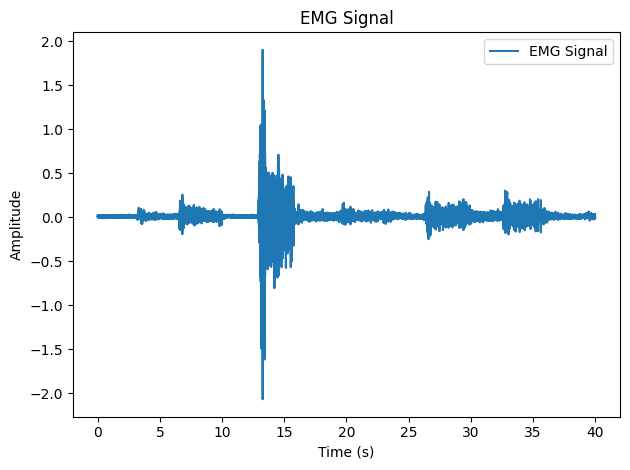

In [4]:
# Original signal
# Extract the signal
signal = df['EMG Signal']

# Graph of the original Signal
fig, ax = plt.subplots()
ax.plot(df['Time (s)'], signal, label='EMG Signal')  # Replace column names as needed
ax.set_title("EMG Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.legend()

plt.tight_layout()
plt.show()

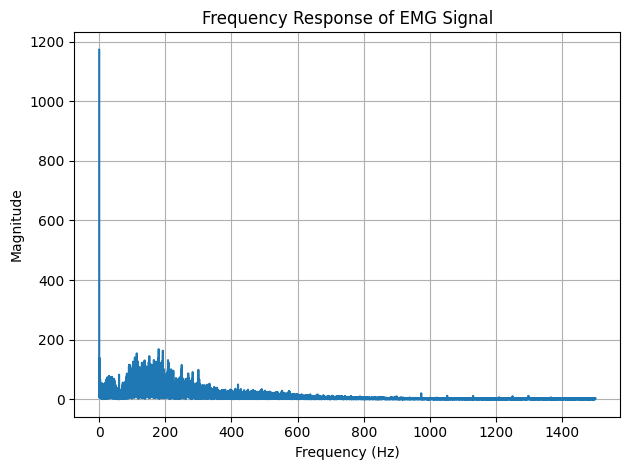

In [5]:
# FFT of the original signal
n = len(signal)
fft_signal = np.fft.fft(signal)
fft_freq = np.fft.fftfreq(n, d=1/fs)

# Plot the frequency response
fig, ax = plt.subplots()
ax.plot(fft_freq[:n//2], np.abs(fft_signal)[:n//2])
ax.set_title("Frequency Response of EMG Signal")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude")
ax.grid()

plt.tight_layout()
plt.show()

In [6]:
# Parameters for powerline interference
powerline_freq = 50  # Frequency of powerline interference (Hz)
amplitude = 0.1  # Base amplitude of the interference
variable_amplitude = amplitude * (1 + 0.5 * np.sin(2 * np.pi * 0.1 * df['Time (s)']))  # Variable amplitude
# print(np.mean(variable_amplitude))

# Generate powerline interference
interference = variable_amplitude * np.sin(2 * np.pi * powerline_freq * df['Time (s)'])

signal_with_powerline_interference = signal + interference

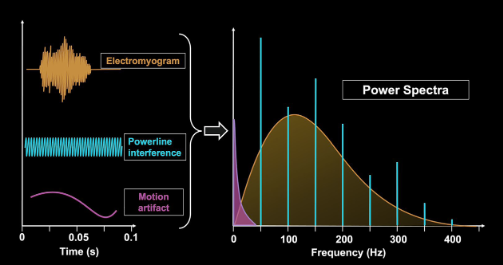

Signal with interference

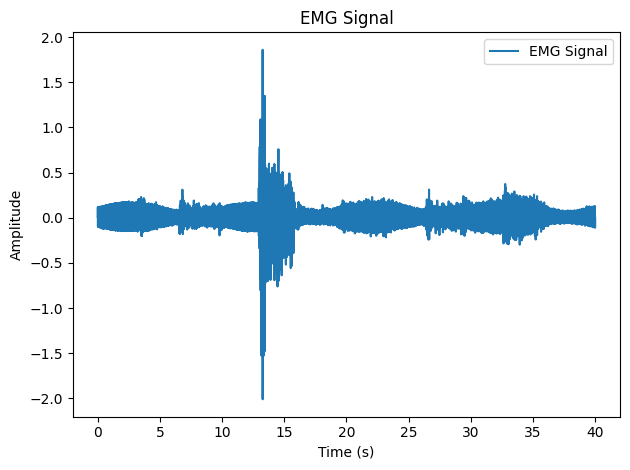

In [7]:
# Graph of the Signal with Powerline Interference
fig, ax = plt.subplots()
ax.plot(df['Time (s)'], signal_with_powerline_interference, label='EMG Signal')  # Replace column names as needed
ax.set_title("EMG Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.legend()

plt.tight_layout()
plt.show()

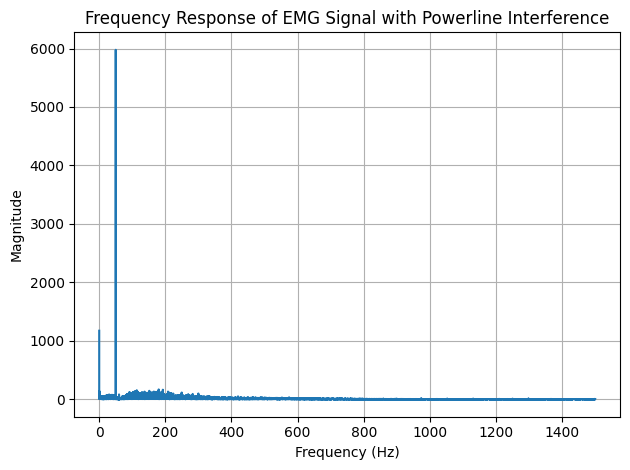

In [8]:
# Compute the FFT of the signal with powerline interference
n = len(signal_with_powerline_interference)
fft_signal_with_interference = np.fft.fft(signal_with_powerline_interference)
fft_freq_with_interference = np.fft.fftfreq(n, d=1/fs)

# Plot the frequency response
fig, ax = plt.subplots()
ax.plot(fft_freq_with_interference[:n//2], np.abs(fft_signal_with_interference)[:n//2])
ax.set_title("Frequency Response of EMG Signal with Powerline Interference")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude")
ax.grid()

plt.tight_layout()
plt.show()

Filering with band-pass

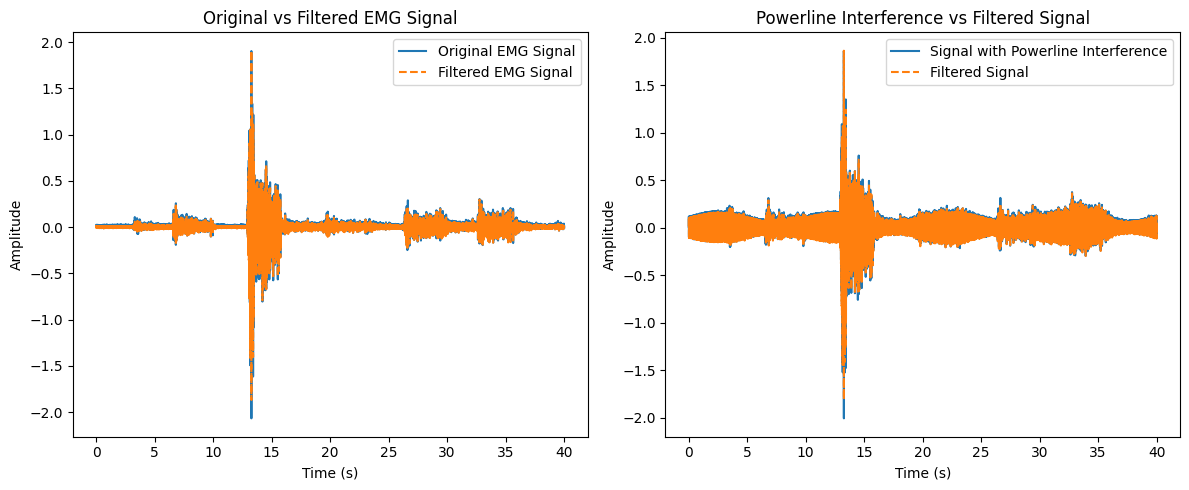

In [9]:
# Design the bandpass filter
lowcut = 20.0
highcut = 500.0
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')

# Apply the filter to the signal
filtered_signal = filtfilt(b, a, signal)
filtered_signal_with_powerline = filtfilt(b, a, signal_with_powerline_interference)

# Plot the original and filtered signals
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1: Original signal vs filtered signal
axs[0].plot(df['Time (s)'], signal, label='Original EMG Signal')
axs[0].plot(df['Time (s)'], filtered_signal, label='Filtered EMG Signal', linestyle='--')
axs[0].set_title("Original vs Filtered EMG Signal")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].legend()

# Subplot 2: Signal with powerline interference vs filtered signal
axs[1].plot(df['Time (s)'], signal_with_powerline_interference, label='Signal with Powerline Interference')
axs[1].plot(df['Time (s)'], filtered_signal_with_powerline, label='Filtered Signal', linestyle='--')
axs[1].set_title("Powerline Interference vs Filtered Signal")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Amplitude")
axs[1].legend()

plt.tight_layout()
plt.show()

signal = filtered_signal
signal_with_powerline_interference = filtered_signal_with_powerline

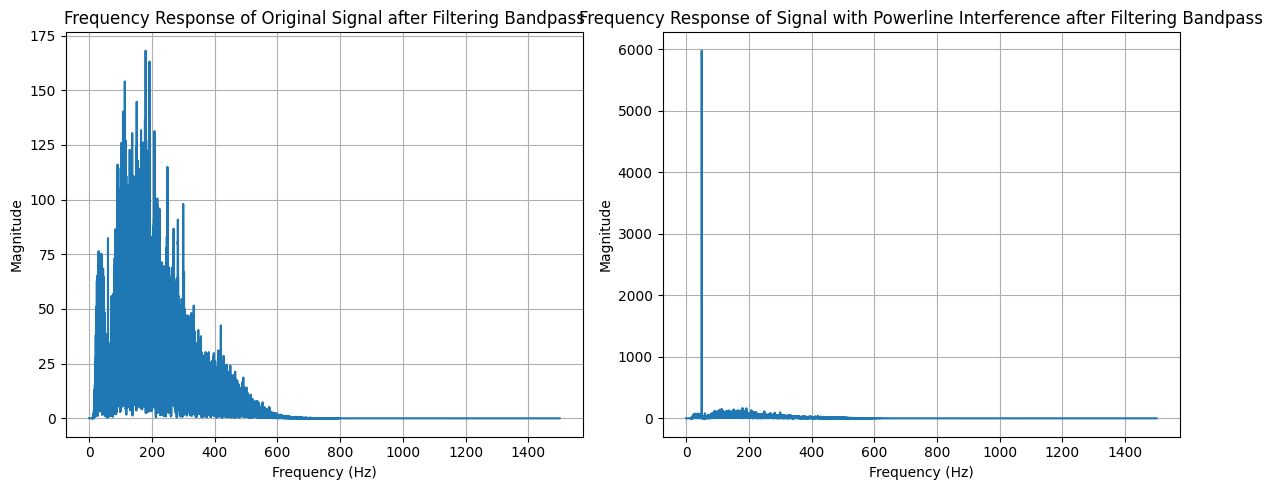

In [10]:
# Compute the FFT of the signal with powerline interference
n_interference = len(signal_with_powerline_interference)
fft_signal_with_interference = np.fft.fft(signal_with_powerline_interference)
fft_freq_with_interference = np.fft.fftfreq(n_interference, d=1/fs)

n = len(signal)
fft_signal = np.fft.fft(signal)
fft_freq = np.fft.fftfreq(n, d=1/fs)

# Plot the frequency responses side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1: FFT of the original signal
axs[0].plot(fft_freq[:n//2], np.abs(fft_signal)[:n//2])
axs[0].set_title("Frequency Response of Original Signal after Filtering Bandpass")
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Magnitude")
axs[0].grid()

# Subplot 2: FFT of the signal with powerline interference
axs[1].plot(fft_freq_with_interference[:n_interference//2], np.abs(fft_signal_with_interference)[:n_interference//2])
axs[1].set_title("Frequency Response of Signal with Powerline Interference after Filtering Bandpass")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Magnitude")
axs[1].grid()

plt.tight_layout()
plt.show()

### CWT

https://pywavelets.readthedocs.io/en/latest/ref/cwt.html

Our region of interest:

> The EMG signal covers frequency in the range of 20 to 500 Hz. 
> -- <cite>[Continuous Wavelet Transform Analysis of SurfaceElectromyography for Muscle Fatigue Assessmenton the Elbow Joint Motion][1]</cite>

[1]: https://www.researchgate.net/publication/320162739_Continuous_Wavelet_Transform_Analysis_of_Surface_Electromyography_for_Muscle_Fatigue_Assessment_on_the_Elbow_Joint_Motion

While the full range can extend from 6 to 500 Hz, the most significant power of the signal is often found within the 20-250 Hz band

In [38]:
# Arguments for CWT
dt = 1 / fs # Sampling period in seconds
print(f"Sampling period: {dt:.6f} s")

'''
For the cmor, fbsp and shan wavelets, the user can specify a specific a normalized center frequency. 
A value of 1.0 corresponds to 1/dt where dt is the sampling period. In other words, when analyzing a signal sampled at 100 Hz, a center frequency of 1.0 corresponds to ~100 Hz at scale = 1. 
This is above the Nyquist rate of 50 Hz, so for this particular wavelet, one would analyze a signal using scales >= 2.
'''

# Wvelet parameters
B = 1.5 # Bandwidth
C = 1.0 # Center frequency
wavelet = 'cmor'+ str(B) + '-' + str(C)
print(f"Wavelet: {wavelet}")

'''
For each of the wavelets described below, the implementation in PyWavelets evaluates the wavelet function for 
 over the range [wavelet.lower_bound, wavelet.upper_bound] (with default range ). scale = 1 corresponds to the case where the extent of the 
 wavelet is (wavelet.upper_bound - wavelet.lower_bound + 1) samples of the digital signal being analyzed. 
Larger scales correspond to stretching of the wavelet. For example, at scale=10 the wavelet is stretched by a factor of 10, making it sensitive to lower frequencies in the signal.

To relate a given scale to a specific signal frequency, the sampling period of the signal must be known. pywt.scale2frequency() can be used to convert a list of scales to their corresponding frequencies. 
The proper choice of scales depends on the chosen wavelet, so pywt.scale2frequency() should be used to get an idea of an appropriate range for the signal of interest.
'''

#Scales
wav = pywt.ContinuousWavelet(wavelet) 
width = wav.upper_bound - wav.lower_bound
print("width:",width)

# 2 different cases for scales according to literature and their log scale
all_frequencies = np.array([6, 500])
significant_frequencies = np.array([20, 250])
all_frequencies_log = np.geomspace(6, 500, num=100)
significant_frequencies_log = np.geomspace(20, 250, num=100)

Sampling period: 0.000333 s
Wavelet: cmor1.5-1.0
width: 16.0


Choose which scales for what freq. ranges to use

In [39]:

# Comment one you dont want to use !

# frequencies = all_frequencies / fs # normalized 
# frequencies = significant_frequencies / fs # normalized
# frequencies = all_frequencies_log / fs # normalized
frequencies = significant_frequencies_log / fs # normalized

In [40]:

scales = pywt.frequency2scale(wavelet, frequencies)
print(scales)

'''
To convert frequency to scale for use in the wavelform tet transhe function pywt.frequency2scale() can be used. This is the complement of the pywt.scale2frequency() function as seen in the previous section. 
Note that the input frequency in this function is normalized by 1/dt, or the sampling frequency fs. This function is useful for specifying the transform as a function of frequency directly.
'''

frequencies = pywt.scale2frequency(wavelet, [500, 6]) / dt
print(frequencies)

[150.         146.22154214 142.53826258 138.94776379 135.44770866
 132.03581894 128.70987375 125.4677082  122.30721188 119.22632757
 116.22304988 113.29542391 110.44154401 107.65955255 104.94763867
 102.30403714  99.72702718  97.21493139  94.76611458  92.37898278
  90.05198216  87.78359803  85.57235386  83.41681031  81.31556429
  79.26724807  77.27052837  75.32410547  73.42671241  71.57711416
  69.77410676  68.01651662  66.30319967  64.6330407   63.00495257
  61.41787551  59.87077648  58.36264845  56.89250973  55.45940339
  54.0623966   52.70058002  51.37306722  50.07899409  48.8175183
  47.58781873  46.38909494  45.22056668  44.08147331  42.97107338
  41.88864411  40.83348094  39.80489703  38.80222285  37.82480576
  36.87200953  35.94321397  35.03781451  34.15522181  33.29486137
  32.45617316  31.63861128  30.84164355  30.06475121  29.30742858
  28.56918269  27.849533    27.14801109  26.46416032  25.79753556
  25.14770288  24.51423931  23.89673251  23.29478053  22.70799156
  22.135983

Choose which signal to use

In [41]:
# signal = signal_with_powerline_interference
signal = signal

Shape of CWT matrix: (100, 120001)
Shape of frequencies: (100,)
Shape of time: (120001,)


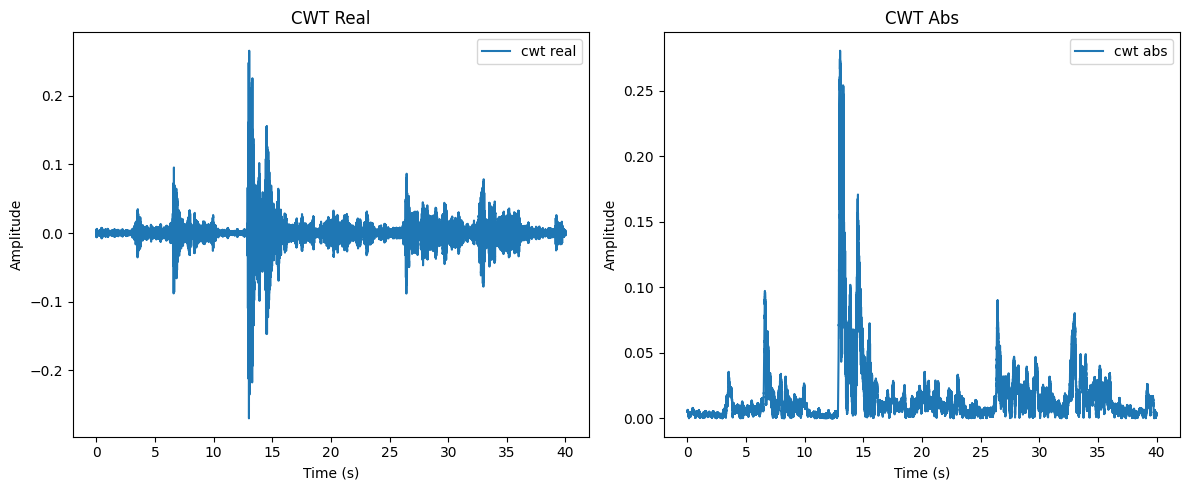

In [42]:
'''
coefs, frequencies = pywt.cwt(signal, scales, wavelet)

where:
Input: 
    Mandatory:
    - signal: The input signal to be analyzed.
    - scales: The wavelet scales to use. One can use f = scale2frequency(wavelet, scale)/sampling_period to determine what physical frequency, f. 
            Here, f is in hertz when the sampling_period is given in seconds.
    - wavelet: The wavelet function to use for the CWT.
    Optional:
    - sampling_period: 1/fs.
    - method: {'fft', 'conv'}. The method used to compute the CWT. Can be any of:
       1 conv uses numpy.convolve.
       2 fft uses frequency domain convolution.
       3 auto uses automatic selection based on an estimate of the computational complexity at each scale.
         The conv method complexity is O(len(scale) * len(data)). The fft method is O(N * log2(N)) with N = len(scale) + len(data) - 1. It is well suited for large size signals but slightly slower than conv on small ones.
    - axis: Axis over which to compute the CWT. If not given, the last axis is used.
Output:
    - coefs: Continuous wavelet transform of the input signal for the given scales and wavelet. The first axis of coefs corresponds to the scales. The remaining axes match the shape of data.
    - frequencies: If the unit of sampling period are seconds and given, then frequencies are in hertz. Otherwise, a sampling period of 1 is assumed.
'''

cwtmatr, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=dt)

print(f"Shape of CWT matrix: {cwtmatr.shape}")
print(f"Shape of frequencies: {freqs.shape}")
print(f"Shape of time: {df['Time (s)'].shape}")

'''
cwtmatr:
-real: filtered signal for the given scales.
-abs: envelope of the filtered signal for the given scales.
'''

# Graph of the cwt real and cwt abs side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot cwt real
axs[0].plot(df['Time (s)'], np.real(cwtmatr[0, :]), label='cwt real')
axs[0].set_title("CWT Real")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].legend()

# Plot cwt abs
axs[1].plot(df['Time (s)'], np.abs(cwtmatr[0, :]), label='cwt abs')
axs[1].set_title("CWT Abs")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Amplitude")
axs[1].legend()

plt.tight_layout()
plt.show()


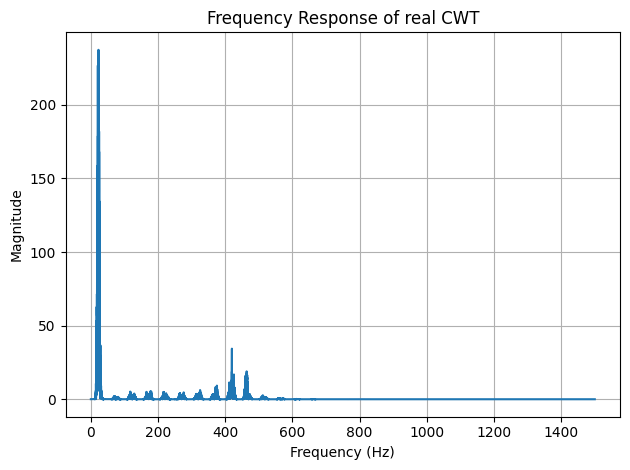

In [43]:
# fft of the real cwt
n = len(np.real(cwtmatr[0,:]))
fft_signal = np.fft.fft(np.real(cwtmatr[0,:]))
fft_freq = np.fft.fftfreq(n, d=1/fs)

# Plot the frequency response
fig, ax = plt.subplots()
ax.plot(fft_freq[:n//2], np.abs(fft_signal)[:n//2])
ax.set_title("Frequency Response of real CWT")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude")
ax.grid()

plt.tight_layout()
plt.show()


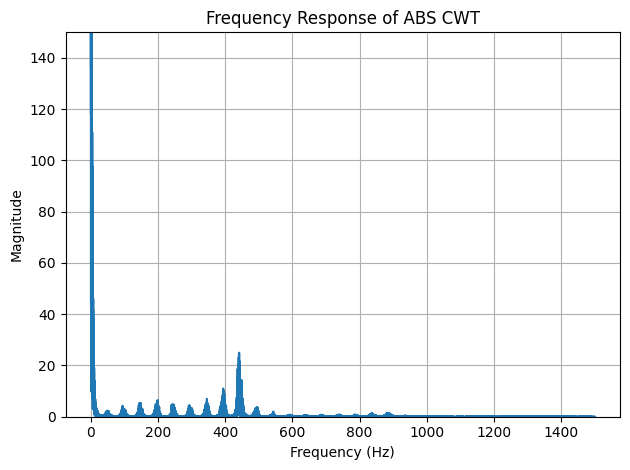

In [44]:
# fft of the abs cwt 
n = len(np.abs(cwtmatr[0,:]))
fft_signal = np.fft.fft(np.abs(cwtmatr[0,:]))
fft_freq = np.fft.fftfreq(n, d=1/fs)

# Plot the frequency response
fig, ax = plt.subplots()
ax.plot(fft_freq[:n//2], np.abs(fft_signal)[:n//2])
ax.set_title("Frequency Response of ABS CWT")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude")
ax.grid()

plt.ylim(0, 150)

plt.tight_layout()
plt.show()

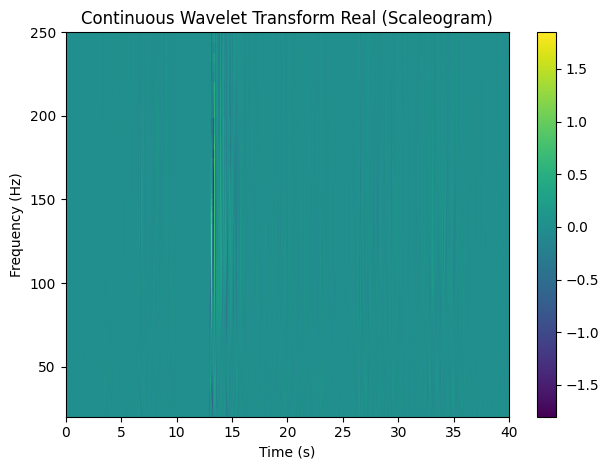

In [45]:
cwtmatr, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=dt)

# Plot result using matplotlib's pcolormesh (image with annotated axes)
fig, ax = plt.subplots()
pcm = ax.pcolormesh(df["Time (s)"], freqs, np.real(cwtmatr[:-1,:-1]))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Continuous Wavelet Transform Real (Scaleogram)")
# ax.set_xlim([10, 15])
fig.colorbar(pcm, ax=ax)
plt.tight_layout()
plt.show()

### FFC filter for comparison

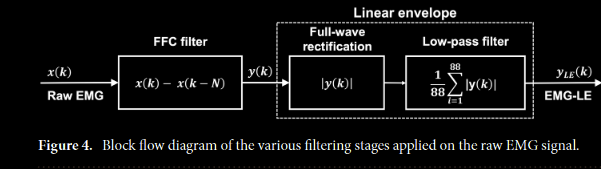

Feed-forward comb filter. The FFC filter operation is based on adding a delayed version of the input sig-
nal to itself, so as to produce constructive and destructive interference. The destructive interference mechanism
is precisely that used to cut off a specific frequency component, along with its harmonics. The general difference
equation of the FFC filter can be expressed as follows:
$$y(k) = x(k) + αx(k − N)$$
where x is the input signal, N is the delay expressed in number of samples, and α is a parameter that regulates
some aspects of the filter behaviour. In particular, when α is equal to ± 1, the minima of the FFC amplitude
response are equal to zero, so they become nulls of the amplitude response.

[Paper about FFC](https://www.nature.com/articles/s41598-023-33319-4)


In [46]:
# Define the comb filter
def comb_filter(signal, delay, alpha):
    b = np.zeros(delay + 1)
    b[0] = 1
    b[-1] = -alpha
    a = [1]
    return lfilter(b, a, signal)

# Parameters for the comb filter
delay = int(fs / 50)  # Delay in samples (for 50 Hz)
alpha = 0.95  # Feedback coefficient

In [47]:
# signal = signal_with_powerline_interference
signal = signal

In [48]:
# Apply the comb filter to the signal
filtered_signal_FFC = comb_filter(signal, delay, alpha)

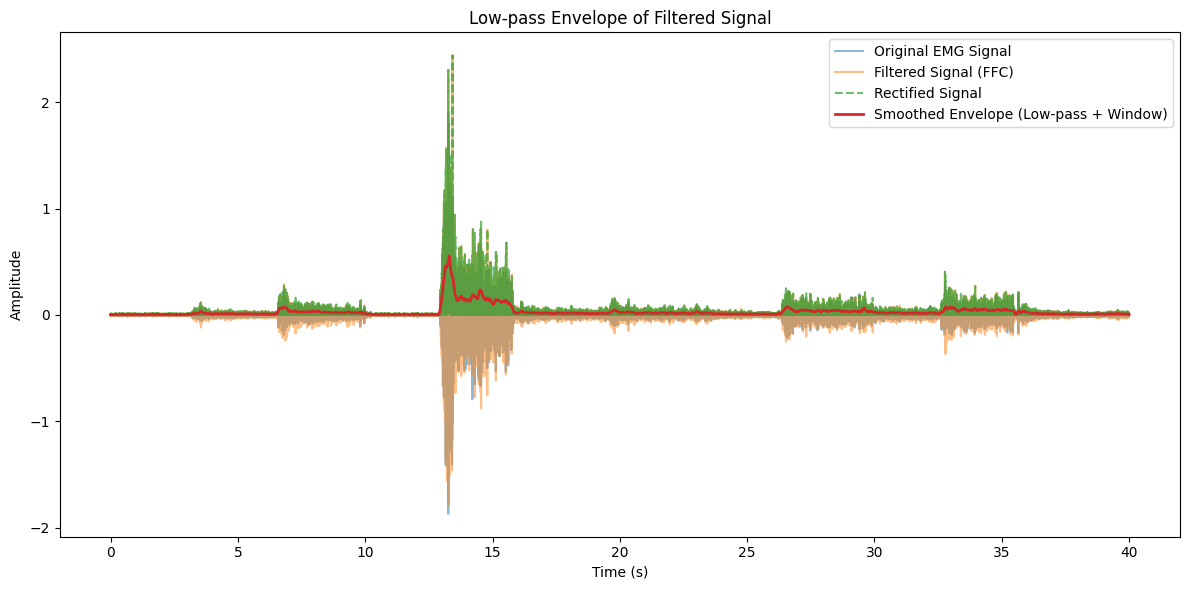

In [49]:
# Step 1: Rectify the signal (take the absolute value)
rectified_signal = np.abs(filtered_signal_FFC)

# Step 2: Design a low-pass filter
lowcut = 20.0  # Low-pass cutoff frequency in Hz
nyquist = 0.5 * fs
low = lowcut / nyquist
b, a = butter(4, low, btype='low')

# Step 3: Apply the low-pass filter to the rectified signal
smoothed_envelope = filtfilt(b, a, rectified_signal)

# Step 4: (Optional) Apply a moving average (windowing) for additional smoothing
window_size = int(0.1 * fs)  # 100 ms window
window = np.ones(window_size) / window_size
smoothed_envelope = np.convolve(smoothed_envelope, window, mode='same')

# Step 5: Plot the original signal, rectified signal, and smoothed envelope
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['Time (s)'], signal, label='Original EMG Signal', alpha=0.5)
ax.plot(df['Time (s)'], filtered_signal_FFC, label='Filtered Signal (FFC)', alpha=0.5)
ax.plot(df['Time (s)'], rectified_signal, label='Rectified Signal', linestyle='--', alpha=0.7)
ax.plot(df['Time (s)'], smoothed_envelope, label='Smoothed Envelope (Low-pass + Window)', linewidth=2)
ax.set_title("Low-pass Envelope of Filtered Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.legend()

plt.tight_layout()
plt.show()

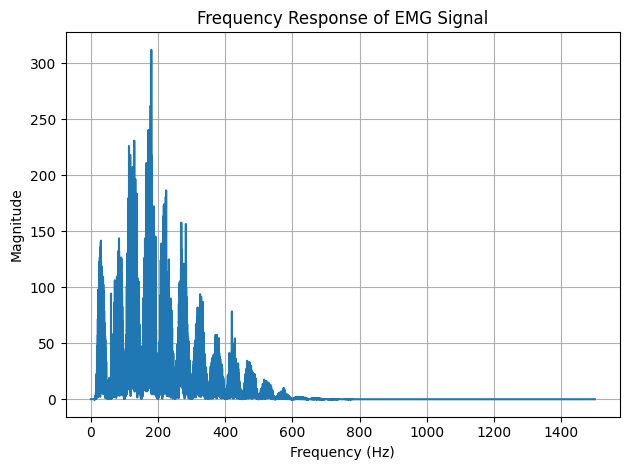

In [50]:
# Compute the FFT
n = len(filtered_signal_FFC)
fft_signal = np.fft.fft(filtered_signal_FFC)
fft_freq = np.fft.fftfreq(n, d=1/fs)

# Plot the frequency response
fig, ax = plt.subplots()
ax.plot(fft_freq[:n//2], np.abs(fft_signal)[:n//2])
ax.set_title("Frequency Response of EMG Signal")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude")
ax.grid()

plt.tight_layout()
plt.show()